# **Silent Help: Arabic Lip Reading Emergency System (SHARES)**

SHARES is a deep-learning-based Arabic lip-reading system designed for emergency scenarios. It leverages modern computer vision techniques to assist individuals who cannot communicate verbally. The model is fine-tuned to recognize emergency-related Arabic lip movements, ensuring rapid and accurate interpretation.

**Contributors**:

*   **Naif Alharbi**
*   **Sultan Alqili**
*   **Yasser Alharbi**
*   **Nawaf Alandijany**  
*   **Abdulaziz Abutaleb**

# Methodology for Fine-Tuning SHARES

## Dataset
### 1. Data Collection
- **Source Data**: **``Properitery dataset``**
- Our dataset consists of videos containing Arabic emergency-related words.
These videos are collected under controlled conditions (speakers, background, etc.) and annotated with their respective words (e.g., "اسعاف", "حريق", "النجدة", etc.). Since this dataset is proprietary, it is not publicly available for direct download.

---
### 2. Data Cleaning and Standardization
Before processing, we ensure:
1. **File Format Consistency:** We limit video files to standard formats such as .mp4, .avi, etc.
2. **Corrupted Files Check:** Any corrupted or invalid videos are skipped and logged.
3. **Directory Structure:** Each word folder is consistently named, with subfolders holding the raw videos and extracted frames.

---
### 3. Data Preparation
We prepare the data by extracting frames from each video, resizing them, and storing them in a consistent format. Specifically:
1. **Frame Extraction:**
- We define a function `extract_frames_full_coverage` that reads each video and extracts a fixed number of frames (e.g., 20) evenly spaced over the video's duration.
- Each extracted frame is resized to 224 x 224 pixels and saved in a frames subfolder.
2. **Visualization:**
- After extraction, we randomly visualize a few frames from a random word to ensure that frames are of the correct size and are in the right order.
3. **DataFrame Creation:**
- We create a CSV file `(dataset_mapping.csv)` mapping each word to the directory containing its extracted frames. This is useful for quickly iterating over your dataset during preprocessing.
4. **Preprocessing:**
- Each set of 20 frames is further normalized (pixel values scaled to [0, 1]) and then prepared as NumPy arrays.
- We convert class labels (Arabic words) to one-hot encodings for easier training in neural networks.
- Finally, we split the data into Train, Development (Dev), and Test sets. In the example code, we use an 80/10/10 split to ensure a balanced distribution.

---
### 4. Data Augmentation
To address the limited size of our dataset (330 video samples) and the subtle nature of lip movements, we implemented a tailored data augmentation pipeline to artificially increase sample variability.

**Augmentation Strategy:**
- *Independently on each frame*, creating high variabil-
ity between consecutive frames, or
- *Consistently across all frames*, preserving the tempo-
ral coherence of natural head movements.

---
## Fine-Tuning

### ResNet
Here, we adapt a pretrained R(2+1)D (ResNet-based) model from torchvision.models.video for our lip-reading task. We specifically choose R(2+1)D because it is known for its effectiveness in video-related tasks, combining 2D and 1D convolutions for motion modeling. Below is a breakdown:
1. **Data Loading:**
- We wrap our preprocessed NumPy arrays into a custom LipReadingDataset class, which inherits from torch.utils.data.Dataset. This class handles:

- - Converting the numpy arrays to Torch tensors.
- - Permuting dimensions so the input shape matches the model’s expected format (Batch, Channels, Frames, Height, Width).
- - Converting labels to integer indices (if they are in one-hot form).
---
2. **Model Architecture:**
- We load `r2plus1d_18` with pretrained weights from `R2Plus1D_18_Weights.DEFAULT`.
- The last fully connected layer is replaced with a custom head:
```python
nn.Sequential(
    nn.Linear(in_features, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, num_classes)
)
```
---
3. **Training Loop:**
- **Loss Function:** We use CrossEntropyLoss suitable for multi-class classification.
- **Optimizer:** `AdamW` is chosen with a moderate learning rate (1e-4) and a weight decay to regularize.
- **Learning Rate Scheduler:** `ReduceLROnPlateau` monitors validation loss and reduces the learning rate if improvement stalls.
- **Epochs:** We run multiple epochs (e.g., 50), monitoring both the training and development sets for losses and accuracies. The model with the best validation accuracy is saved.
- **Early Stopping:** If the development-set loss fails to
 improve for patience epochs (set to 30 in our experi
ments), training is halted to prevent overfitting.
---

##  Model Evaluation
- **Testing**: Once training completes (or halts early based on a stopping criterion), we load the best-performing checkpoint and evaluate on the Test set. This ensures an unbiased estimate of how well the model generalizes to unseen data.

- **Metrics**:
- - **Accuracy:** Gives a straightforward measure of overall classification performance.
- - **Precision, Recall, F1:** For each class, we generate a classification report. These metrics help analyze whether certain emergency words are prone to misclassification.
- - **Confusion Matrix:** Visualizes how often a model confuses one word with another.


## **Packages**

In [ ]:
import os
import cv2
import csv
import random
import base64
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Javascript, display
from google.colab import output
import torchvision.transforms as T
import torchvision.transforms.functional as F
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [ ]:
base_dir = "/content/drive/MyDrive/NAIF_Arabic_Lip_Reading/Emergency_Arabic_Lip_Reading_(VIDS)"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Collecting the dataset + preprocessing it**

In [ ]:
# fixed_width, fixed_height = 224, 224  # Desired frame size (e.g., 224x224)

# def extract_frames_full_coverage(video_path, output_folder, num_frames=20):
#     """
#     Extract evenly spaced frames across the entire video and resize them.
#     """
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     cap = cv2.VideoCapture(video_path)
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = cap.get(cv2.CAP_PROP_FPS)

#     if not cap.isOpened() or total_frames == 0 or fps == 0:
#         print(f"Error: Skipping invalid or empty video: {video_path}")
#         cap.release()
#         return

#     total_duration = total_frames / fps  # Duration in seconds
#     frame_times = [i * total_duration / num_frames for i in range(num_frames)]

#     for frame_count, time in enumerate(frame_times):
#         cap.set(cv2.CAP_PROP_POS_MSEC, time * 1000)
#         ret, frame = cap.read()
#         if ret:
#             resized_frame = cv2.resize(frame, (fixed_width, fixed_height))
#             frame_file = os.path.join(output_folder, f"frame_{frame_count + 1:03d}.jpg")
#             cv2.imwrite(frame_file, resized_frame)
#         else:
#             print(f"Warning: Could not read frame at {time:.2f} seconds in {video_path}")

#     cap.release()

In [ ]:
# # Process the videos in the directory structure
# for word_folder in os.listdir(base_dir):
#     word_path = os.path.join(base_dir, word_folder)

#     if os.path.isdir(word_path):  # Check if it's a directory
#         for subfolder in os.listdir(word_path):
#             subfolder_path = os.path.join(word_path, subfolder)

#             if os.path.isdir(subfolder_path):  # Check if it's a subfolder
#                 frames_output_folder = os.path.join(subfolder_path, "frames")

#                 # Remove old frames folder (if exists) and recreate it
#                 if os.path.exists(frames_output_folder):
#                     for file in os.listdir(frames_output_folder):
#                         os.remove(os.path.join(frames_output_folder, file))

#                 os.makedirs(frames_output_folder, exist_ok=True)

#                 for video_file in os.listdir(subfolder_path):
#                     video_path = os.path.join(subfolder_path, video_file)
#                     if video_file.endswith(('.mp4', '.avi', '.mov', '.mkv', '.MP4')):  # Check video format
#                         print(f"Processing: {video_path}")
#                         extract_frames_full_coverage(video_path, frames_output_folder)

# print("Processing complete! Resized frames are saved in their respective subfolders.")

## **Data Visualization**

### Random Frames

Selected Word: انتبه


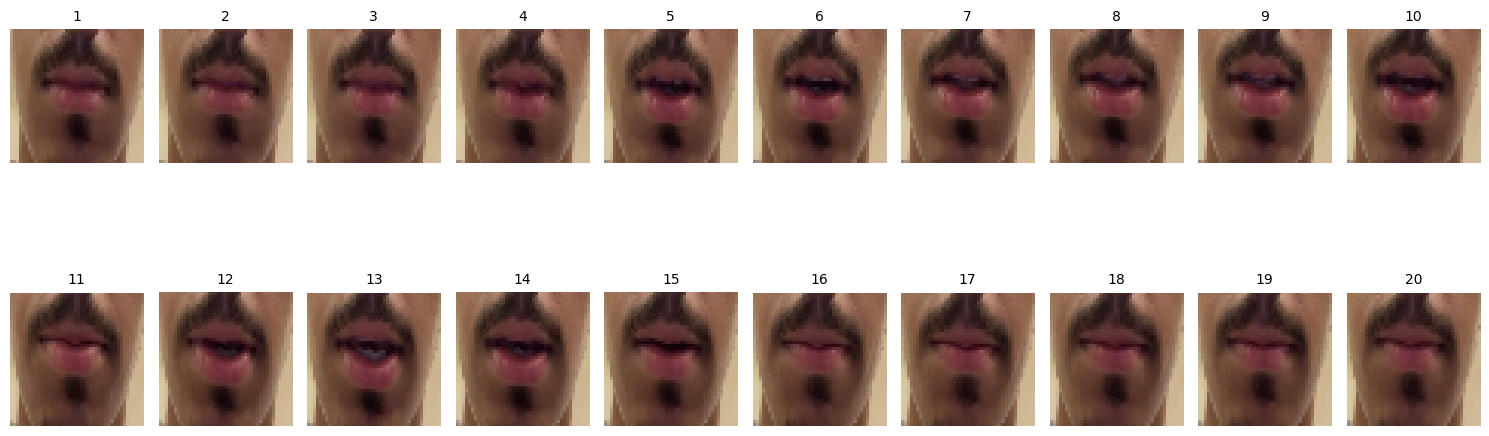

In [ ]:
def visualize_frames_in_rows_with_word(base_dir, num_frames=20, resize_factor=0.5):
    """
    Visualize frames in three rows with clean titles and resized images, showing the word name.

    Args:
        base_dir (str): Base directory containing word folders.
        num_frames (int): Number of frames to visualize (default: 30).
        resize_factor (float): Factor to resize the images (default: 0.5 for smaller display).
    """
    # Get all word folders
    word_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

    # Randomly select a word folder
    selected_word = random.choice(word_folders)
    word_path = os.path.join(base_dir, selected_word)

    # Get all numbered subfolders
    numbered_folders = [f for f in os.listdir(word_path) if os.path.isdir(os.path.join(word_path, f))]

    # Randomly select a numbered subfolder
    selected_number = random.choice(numbered_folders)
    number_path = os.path.join(word_path, selected_number)

    # Get the frames folder path
    frames_folder = os.path.join(number_path, "frames")

    # Check if the frames folder exists
    if not os.path.exists(frames_folder):
        print(f"No frames found in: {frames_folder}")
        return

    # Get all frame files sorted in order
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith(".jpg")])

    # Limit to the first `num_frames`
    frame_files = frame_files[:num_frames]

    # Print the selected word as output
    print(f"Selected Word: {selected_word}")

    # Plot the frames in three rows
    plt.figure(figsize=(15, 7))  # Adjust the figure size as needed

    for i, frame_file in enumerate(frame_files):
        frame_path = os.path.join(frames_folder, frame_file)
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image for visualization
        height, width, _ = img.shape
        resized_img = cv2.resize(img, (int(width * resize_factor), int(height * resize_factor)))  # Resize here

        # Plot in the correct row and column
        plt.subplot(2, 10, i + 1)  # 2 rows, 10 columns
        plt.imshow(resized_img)
        frame_number = int(frame_file.split("_")[-1].split(".")[0])  # Extract number from filename
        plt.title(f"{frame_number}", fontsize=10)  # Use only the number as the title
        plt.axis("off")

    # Reduce gaps between rows
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ensure title doesn't overlap
    plt.show()

# Run the visualization
visualize_frames_in_rows_with_word(base_dir, num_frames=20, resize_factor=0.2)

## **Creating Dataframe**


In [ ]:
# Create a CSV file to map frames to labels
mapping_file = "dataset_mapping.csv"
with open(mapping_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["word", "path_to_frames"])
    for word in os.listdir(base_dir):
        word_path = os.path.join(base_dir, word)
        if os.path.isdir(word_path):
            for sample in os.listdir(word_path):
                sample_path = os.path.join(word_path, sample, "frames")
                if os.path.isdir(sample_path):
                    writer.writerow([word, sample_path])
df = pd.read_csv(mapping_file)

In [ ]:
df

,word,path_to_frames
0,ساعدني,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
1,ساعدني,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
2,ساعدني,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
3,ساعدني,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
4,ساعدني,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
...,...,...
325,خطر,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
326,خطر,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
327,خطر,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...
328,خطر,/content/drive/MyDrive/NAIF_Arabic_Lip_Reading...


## **Preprocess the frames from the df**

In [ ]:
def preprocess_frames_parallel(frame_dir, target_size=(224, 224)):
    """
    Preprocess frames in parallel.
    """
    frame_files = sorted(
        [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")]
    )

    def process_frame(frame_path):
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize pixel values to [0,1]
        return frame

    with ThreadPoolExecutor() as executor:
        frames = list(executor.map(process_frame, frame_files))
    return np.array(frames)



In [ ]:
# Process dataset row by row
X = []
y = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing dataset"):
    frames = preprocess_frames_parallel(row['path_to_frames'])
    if len(frames) == 20:  # Ensure each sample has 20 frames
        X.append(frames)
        y.append(row['word'])  # Save the label (word)

Processing dataset: 100%|██████████| 330/330 [00:18<00:00, 17.38it/s]


In [ ]:
print(f"Number of samples: {len(X)}")
print(f"Number of labels: {len(y)}")

Number of samples: 330
Number of labels: 330


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded labels:", y_encoded)
print("Label mapping (index -> word):")
for idx, word in enumerate(le.classes_):
    print(f"  {idx}: {word}")

# Now use the encoded labels (integers) directly.
y = y_encoded

Encoded labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Label mapping (index -> word):
  0: اسعاف
  1: النجدة
  2: انتبه
  3: اهرب
  4: جريح
  5: حريق
  6: خطر
  7: ساعدني
  8: شرطة
  9: مساعدة


In [ ]:
X = np.array(X)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Dev:  ", X_dev.shape, y_dev.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (264, 20, 224, 224, 3) (264,)
Dev:   (33, 20, 224, 224, 3) (33,)
Test:  (33, 20, 224, 224, 3) (33,)


# Fine tune (ResNet)

In [ ]:
class VideoAugment:
    """
    Applies random transformations to each frame in the video.
    """
    def __init__(self, apply_consistent=False):
        self.apply_consistent = apply_consistent
        self.transforms = T.Compose([
            T.ToPILImage(),
            T.RandomRotation(degrees=2),
            T.RandomHorizontalFlip(p=0.2),
            T.ColorJitter(brightness=0.1, contrast=0.1),
            T.ToTensor(),
        ])

    def __call__(self, video_tensor):
        c, t, h, w = video_tensor.shape
        if self.apply_consistent:
            angle = random.uniform(-8, 8)
            do_flip = (random.random() < 0.5)
            brightness_factor = random.uniform(0.8, 1.2)
            contrast_factor   = random.uniform(0.8, 1.2)
            augmented_frames = []
            for i in range(t):
                frame = video_tensor[:, i, :, :]
                pil_img = T.ToPILImage()(frame)
                pil_img = F.rotate(pil_img, angle)
                if do_flip:
                    pil_img = F.hflip(pil_img)
                pil_img = F.adjust_brightness(pil_img, brightness_factor)
                pil_img = F.adjust_contrast(pil_img, contrast_factor)
                new_frame = T.ToTensor()(pil_img)
                augmented_frames.append(new_frame.unsqueeze(1))
            augmented_video = torch.cat(augmented_frames, dim=1)
            return augmented_video
        else:
            augmented_frames = []
            for i in range(t):
                frame = video_tensor[:, i, :, :]
                augmented = self.transforms(frame)
                augmented_frames.append(augmented.unsqueeze(1))
            augmented_video = torch.cat(augmented_frames, dim=1)
            return augmented_video

In [ ]:
class LipReadingDataset(Dataset):
    def __init__(self, X, y, transform=None):
        """
        X: shape (N, T, H, W, C)
        y: label-encoded integers
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.X = self.X.permute(0, 4, 1, 2, 3)  # Rearrange to (N, C, T, H, W)
        # If y were one-hot, we would convert it here. Now y is already integer.
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]
        label = self.y[idx]
        if self.transform:
            video = self.transform(video)
        return video, label


In [ ]:
train_transform = VideoAugment(apply_consistent=True)
train_dataset = LipReadingDataset(X_train, y_train, transform=train_transform)
dev_dataset   = LipReadingDataset(X_dev, y_dev, transform=None)
test_dataset  = LipReadingDataset(X_test, y_test, transform=None)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
class LipReadingModel(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        self.base_model = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)
        if freeze_backbone:
            for name, param in self.base_model.named_parameters():
                if "layer4" not in name and "fc" not in name:
                    param.requires_grad = False
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [ ]:
# Displaying the training shape
len(train_dataset)

264

In [ ]:
def train_model(model, train_loader, dev_loader, num_epochs, device, patience=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    no_improve_epochs = 0

    train_losses = []
    val_losses   = []
    train_accuracies = []
    val_accuracies   = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc  = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        dev_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for videos, labels in dev_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        dev_loss = dev_loss / len(dev_loader)
        dev_acc  = 100. * correct / total
        val_losses.append(dev_loss)
        val_accuracies.append(dev_acc)

        scheduler.step(dev_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Dev Loss:   {dev_loss:.4f},   Dev Acc:   {dev_acc:.2f}%")

        if dev_acc > best_val_acc:
            best_val_acc = dev_acc
            torch.save(model.state_dict(), "best_lip_reading_model.pth")
            print(f"Saved new best model (Dev Acc = {dev_acc:.2f}%)")

        if dev_loss < best_val_loss:
            best_val_loss = dev_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break

        print("-" * 60)

    return train_losses, val_losses, train_accuracies, val_accuracies



In [ ]:
num_classes = len(le.classes_)  # Use the number of unique classes from LabelEncoder

In [ ]:
model = LipReadingModel(num_classes).to(device)
num_epochs = 50
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(
    model, train_loader, dev_loader, num_epochs, device
)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 224MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 2.4349, Train Acc: 11.36%
Dev Loss:   2.8076,   Dev Acc:   9.09%
Saved new best model (Dev Acc = 9.09%)
------------------------------------------------------------
Epoch 2/50
Train Loss: 2.3080, Train Acc: 15.91%
Dev Loss:   2.4756,   Dev Acc:   6.06%
------------------------------------------------------------
Epoch 3/50
Train Loss: 2.2896, Train Acc: 15.53%
Dev Loss:   2.3142,   Dev Acc:   3.03%
------------------------------------------------------------
Epoch 4/50
Train Loss: 2.2730, Train Acc: 13.64%
Dev Loss:   2.2370,   Dev Acc:   9.09%
------------------------------------------------------------
Epoch 5/50
Train Loss: 2.1979, Train Acc: 21.21%
Dev Loss:   2.2870,   Dev Acc:   6.06%
------------------------------------------------------------
Epoch 6/50
Train Loss: 2.0695, Train Acc: 29.55%
Dev Loss:   2.3190,   Dev Acc:   12.12%
Saved new best model (Dev Acc = 12.12%)
------------------------------------------------------------
Epoch 7/50
Train Loss: 2.0

# Evaluate

In [ ]:
# Saving the best weights on drive
import shutil
from google.colab import drive
drive.mount('/content/drive')
shutil.copy("best_lip_reading_model.pth", "/content/drive/MyDrive/Best_Model_Wights")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Best_Model_Wights/best_lip_reading_model.pth'

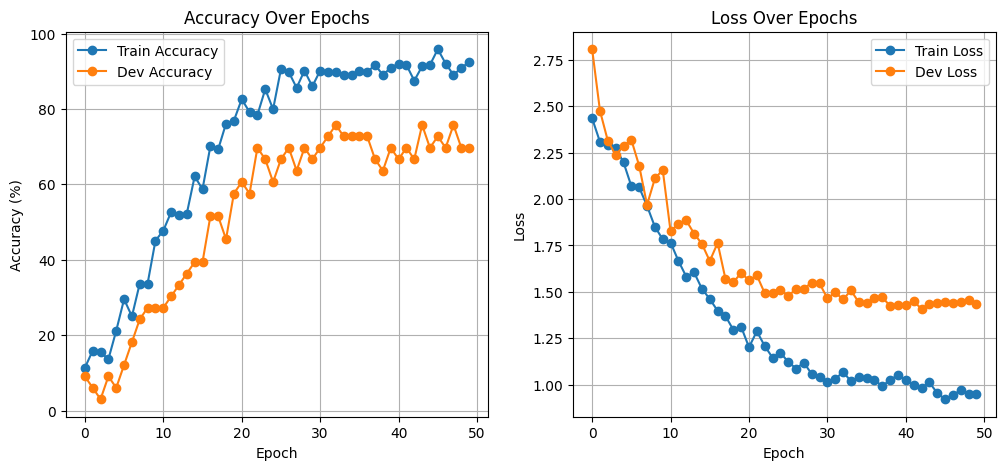

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(dev_accuracies, label='Dev Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(dev_losses, label='Dev Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Load best model
model = LipReadingModel(num_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Best_Model_Wights/best_lip_reading_model(32)(30)(90)(76)(76)(label).pth", map_location=device))
model.eval()

def predict_with_probabilities(model, X_data, device, batch_size=8):
    model.eval()
    X_data_tensor = torch.tensor(X_data, dtype=torch.float32).permute(0, 4, 1, 2, 3)
    data_dataset  = torch.utils.data.TensorDataset(X_data_tensor)
    data_loader   = DataLoader(data_dataset, batch_size=batch_size, shuffle=False)
    all_probs = []
    all_preds = []
    with torch.no_grad():
        for (videos,) in data_loader:
            videos = videos.to(device)
            outputs = model(videos)
            probs   = torch.softmax(outputs, dim=1)
            preds   = probs.argmax(dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    y_prob = np.concatenate(all_probs, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)
    return y_prob, y_pred


<ipython-input-67-520194fc3edb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Best_Model_Wights/best_lip_reading_

Test Accuracy: 0.76
              precision    recall  f1-score   support

       اسعاف       0.67      0.67      0.67         3
      النجدة       0.50      0.25      0.33         4
       انتبه       0.67      1.00      0.80         4
        اهرب       0.67      0.50      0.57         4
        جريح       1.00      1.00      1.00         3
        حريق       0.67      1.00      0.80         2
         خطر       0.71      0.83      0.77         6
      ساعدني       1.00      0.67      0.80         3
        شرطة       1.00      1.00      1.00         2
      مساعدة       1.00      1.00      1.00         2

    accuracy                           0.76        33
   macro avg       0.79      0.79      0.77        33
weighted avg       0.76      0.76      0.74        33



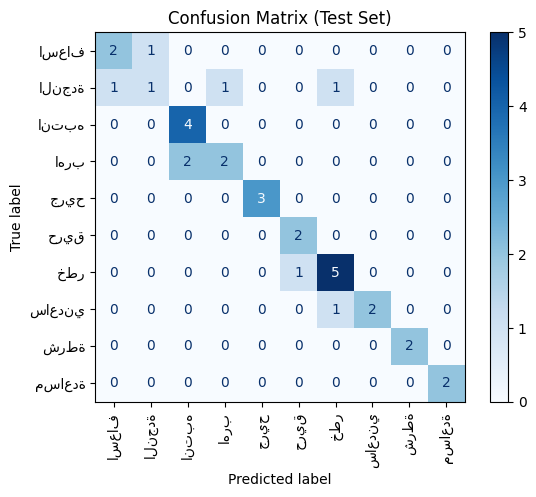

In [ ]:
# Predict on test set (note: y_test is already integer labels)
y_prob_test, y_pred_test = predict_with_probabilities(model, X_test, device, batch_size=8)
y_true_test = y_test  # Already label encoded

test_acc = accuracy_score(y_true_test, y_pred_test)
print(f"Test Accuracy: {test_acc:.2f}")
target_names=[str(label) for label in le.classes_]

# Use the LabelEncoder classes for target names so that index 5 maps to the correct word.
report = classification_report(y_true_test, y_pred_test, target_names=target_names)
print(report)

conf_matrix = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(le.classes_))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix (Test Set)")
plt.show()

Dev Accuracy: 0.76
              precision    recall  f1-score   support

       اسعاف       1.00      0.50      0.67         2
      النجدة       1.00      0.33      0.50         3
       انتبه       1.00      1.00      1.00         2
        اهرب       0.67      1.00      0.80         2
        جريح       0.80      0.80      0.80         5
        حريق       0.50      1.00      0.67         2
         خطر       1.00      0.57      0.73         7
      ساعدني       0.40      1.00      0.57         2
        شرطة       0.80      1.00      0.89         4
      مساعدة       1.00      0.75      0.86         4

    accuracy                           0.76        33
   macro avg       0.82      0.80      0.75        33
weighted avg       0.86      0.76      0.76        33



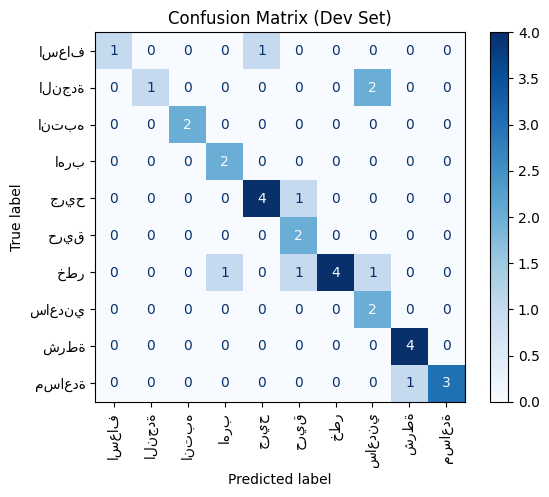

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on dev set (y_dev is already label-encoded)
y_prob_dev, y_pred_dev = predict_with_probabilities(model, X_dev, device, batch_size=8)
y_true_dev = y_dev  # already label-encoded

dev_acc = accuracy_score(y_true_dev, y_pred_dev)
print(f"Dev Accuracy: {dev_acc:.2f}")

# Convert target names to strings
target_names = [str(label) for label in le.classes_]

# Generate classification report
report = classification_report(y_true_dev, y_pred_dev, target_names=target_names)
print(report)

# Display confusion matrix
conf_matrix = confusion_matrix(y_true_dev, y_pred_dev)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix (Dev Set)")
plt.show()
